In [26]:
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from AE_pipeline_pytorch import (
    LSTMAutoencoder,
    BiLSTMAutoencoder,
    GaitAutoencoder,
    
    GaitBatchIterable,

    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    evaluate_autoencoder,
    evaluate_autoencoder_streaming,

    
)

from torch.optim import AdamW
from sklearn.metrics import r2_score



import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score, davies_bouldin_score
)
from collections import Counter
from sklearn.manifold import TSNE




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#Data loader for Zarr datasets
batch_size = 256
train_loader = DataLoader(GaitBatchIterable("train_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


val_loader = DataLoader(GaitBatchIterable("val_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    GaitBatchIterable("test_cycles.zarr", batch_size=batch_size, return_meta=True), 
    batch_size=None, 
    num_workers=4,   
    shuffle=False,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)



In [6]:
#Load the model LSTM autoencoder
model = LSTMAutoencoder(
        n_timesteps=100,
        n_vars=321,
        latent_dim=128,
        dropout=0.4
    )
model_path = "saved_models/best_ae_Torch10_128la_tanh_60ep_ini_l2_parm.pth"

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

LSTMAutoencoder(
  (encoder): LSTM(321, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=128, out_features=321, bias=True)
)

In [ ]:
#Load the model convolutional autoencoder
model = GaitAutoencoder(input_channels=321, seq_length=100, latent_dim=20)
model_path = "best_gait_autoencoder.pt"
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Evaluation and reconstruction 

In [5]:
metrics = evaluate_autoencoder_streaming(model, test_loader, device)
print(f"MSE (streaming): {metrics['mse']:.6f}")
print(f"MAE (streaming): {metrics['mae']:.6f}")

MSE (streaming): 0.454975
MAE (streaming): 0.442544


In [ ]:
# Reconstruct and evaluate on a subset of cycles for specific variables (CONV MODEL)
selected_vars = [313, 314, 315]
MAX_CYCLES  = 200
BATCH_SIZE  = 16
epsilon       = 1e-8

# ─── 1. Muestreo por reservoir (sin acumular todo) ────────────────
reservoir = []   # aquí guardaremos up to MAX_CYCLES ciclos (tensors CPU)
n_seen = 0

with torch.no_grad():
    for batch in test_loader:
        # extrae sólo los datos (batch puede ser (x,meta))
        x_batch = batch[0] if isinstance(batch, (list,tuple)) else batch
        # movemos a CPU para no saturar GPU
        x_cpu = x_batch.cpu()
        for cycle in x_cpu:
            n_seen += 1
            if len(reservoir) < MAX_CYCLES:
                reservoir.append(cycle)
            else:
                j = np.random.randint(0, n_seen)
                if j < MAX_CYCLES:
                    reservoir[j] = cycle

# Si no llenamos el reservoir (dataset pequeño), lo respetamos
M = len(reservoir)
print(f"Reservoir sampling: {M} ciclos almacenados (de {n_seen} vistos).")

# ─── 2. Creamos un DataLoader sólo para esos ciclos ───────────────
sample_cycles = torch.stack(reservoir)        # [M, C, T]
sample_loader = DataLoader(
    sample_cycles,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ─── 3. Reconstrucción y cálculo de métricas sólo sobre selected_vars ──
sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

model.eval()
with torch.no_grad():
    for batch_x in sample_loader:
        batch_x = batch_x.to(device)           # [B, C, T]
        recon, _ = model(batch_x)              # [B, C, T]

        # permutamos a [B, T, C] para indexar variables
        x_orig = batch_x.permute(0,2,1)[..., selected_vars]
        x_rec  = recon     .permute(0,2,1)[..., selected_vars]

        err = x_orig - x_rec
        mse_b  = err.pow(2).mean(dim=(1,2)).cpu().numpy()
        mae_b  = err.abs().mean(dim=(1,2)).cpu().numpy()
        mape_b = (err.abs()/(x_orig.abs()+epsilon)).mean(dim=(1,2)).cpu().numpy()*100

        sum_mse  += mse_b.sum()
        sum_mae  += mae_b.sum()
        sum_mape += mape_b.sum()
        count   += mse_b.shape[0]

mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"\nEvaluación sobre {count} ciclos muestreados:")
print(f"  MSE:  {mse_global:.6f}")
print(f"  MAE:  {mae_global:.6f}")
print(f"  MAPE: {mape_global:.2f}%")

In [9]:
# Reconstruct and evaluate on a subset of cycles for specific variables (LSTM MODEL)
import torch
import numpy as np
from torch.utils.data import DataLoader

# Parámetros
selected_vars = [313, 314, 315]
MAX_CYCLES    = 20
BATCH_SIZE    = 256
epsilon       = 1e-8
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. Muestreo por reservoir (sin acumular todo) ────────────────
reservoir = []   # Up to MAX_CYCLES ciclos (cada uno es [C, T] en CPU)
n_seen = 0

with torch.no_grad():
    for batch in test_loader:  # el iterable que devuelve (x, meta)
        x_batch = batch[0] if isinstance(batch, (list,tuple)) else batch
        x_cpu   = x_batch.cpu()  # [B, C, T]
        for cycle in x_cpu:      # cycle: [C, T]
            n_seen += 1
            if len(reservoir) < MAX_CYCLES:
                reservoir.append(cycle)
            else:
                j = np.random.randint(0, n_seen)
                if j < MAX_CYCLES:
                    reservoir[j] = cycle

M = len(reservoir)
print(f"Reservoir sampling: {M} ciclos almacenados (de {n_seen} vistos).")

# ─── 2. DataLoader para los ciclos muestreados ────────────────────
# Cada ciclo tiene forma [C, T], apilamos a [M, C, T]
sample_cycles = torch.stack(reservoir)
sample_loader = DataLoader(
    sample_cycles,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ─── 3. Reconstrucción + cálculo de métricas ─────────────────────
sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

model.eval()
with torch.no_grad():
    for batch_x in sample_loader:
        # batch_x: [B, C, T] → permutar para LSTM: [B, T, C]
        #x = batch_x.permute(0, 2, 1).to(device)  # [B, T, V]
        x = batch_x.to(device)  # Aseguramos que x esté en el dispositivo correcto

        # encode + decode
        print("Antes de encode, x.shape =", x.shape)
        z     = model.encode(x)                  # [B, latent_dim]
        recon = model.decode(z)                  # [B, T, V]

        # seleccionamos solo las variables de interés
        x_orig = x   [..., selected_vars]        # [B, T, len(selected_vars)]
        x_rec  = recon[..., selected_vars]       # [B, T, len(selected_vars)]

        # errores por ciclo
        err    = x_orig - x_rec
        mse_b  = err.pow(2).mean(dim=(1,2)).cpu().numpy()         # (B,)
        mae_b  = err.abs() .mean(dim=(1,2)).cpu().numpy()         # (B,)
        mape_b = (err.abs()/(x_orig.abs()+epsilon)) \
                      .mean(dim=(1,2)).cpu().numpy() * 100        # (B,)

        sum_mse  += mse_b.sum()
        sum_mae  += mae_b.sum()
        sum_mape += mape_b.sum()
        count   += mse_b.shape[0]

# ─── 4. Métricas globales ────────────────────────────────────────
mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"\nEvaluación LSTM-AE sobre {count} ciclos muestreados:")
print(f"  MSE:  {mse_global:.6f}")
print(f"  MAE:  {mae_global:.6f}")
print(f"  MAPE: {mape_global:.2f}%")


Reservoir sampling: 20 ciclos almacenados (de 35328 vistos).
Antes de encode, x.shape = torch.Size([20, 100, 321])

Evaluación LSTM-AE sobre 20 ciclos muestreados:
  MSE:  0.372708
  MAE:  0.462387
  MAPE: 283.61%


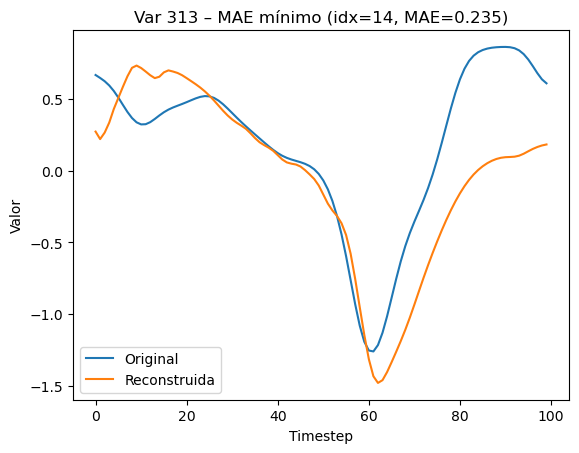

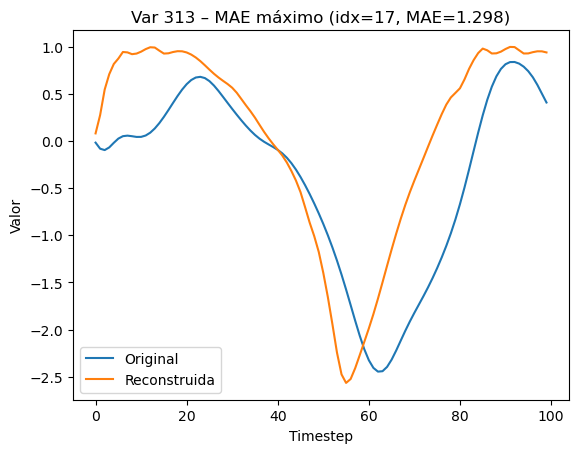

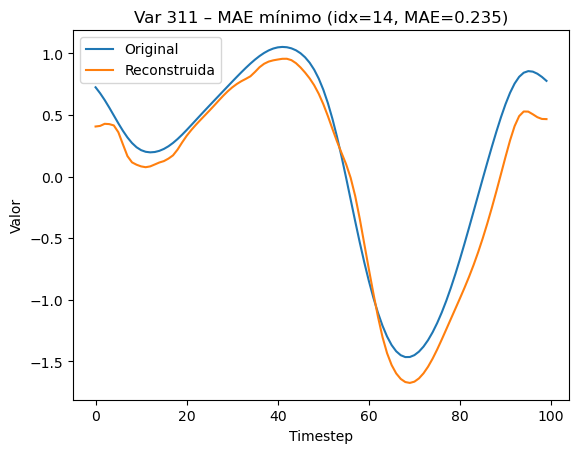

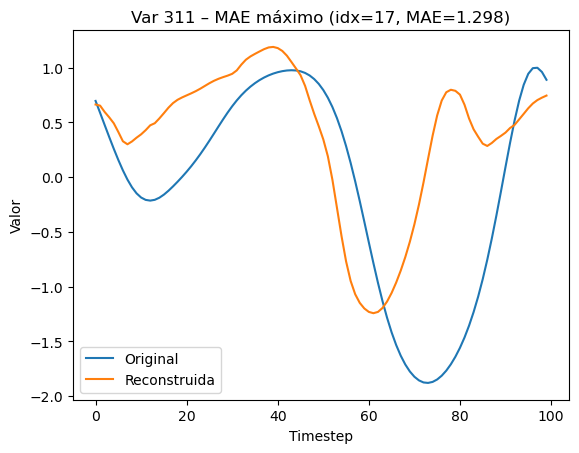

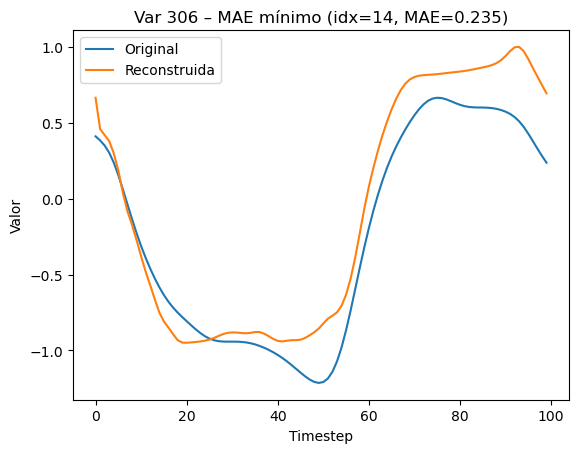

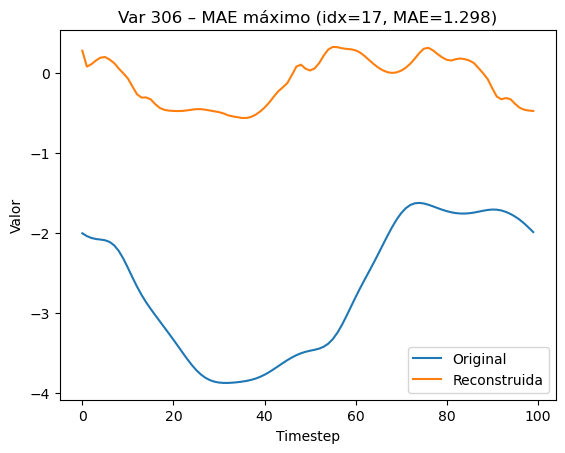

In [10]:
# To plot the reconstructions of the sampled cycles (LSTM MODEL)


# ─── Parámetros ────────────────────────────────────────────────
selected_vars = [313, 311, 306]
BATCH_SIZE    = 16
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. DataLoader sobre sample_cycles (CPU) ────────────────────
# sample_cycles debe ser el tensor [M, C, T] obtenido con reservoir sampling
plot_loader = DataLoader(sample_cycles, batch_size=BATCH_SIZE, shuffle=False)

# ─── 2. Recorrer para recolectar originales, reconstrucciones y MAE ─
orig_list, recon_list, mae_list = [], [], []

model.eval()
with torch.no_grad():
    for batch_x in plot_loader:
        # batch_x: [B, C, T]
        batch_x = batch_x.to(device)

        # 1) Permutar para LSTM: [B, C, T] → [B, T, C]
        #x = batch_x.permute(0, 2, 1)  # [B, T, V]

        # 2) Bottleneck + reconstrucción
        z     = model.encode(x)       # [B, latent_dim]
        recon = model.decode(z)       # [B, T, V]

        # 3) Seleccionar variables de interés (ya en [B, T, V])
        x_orig = x   [..., selected_vars].cpu().numpy()  # (B, T, 3)
        x_rec  = recon[..., selected_vars].cpu().numpy()  # (B, T, 3)

        # 4) Calcular MAE por ciclo
        err      = np.abs(x_orig - x_rec)                # (B, T, 3)
        mae_batch = err.mean(axis=(1,2))                 # (B,)

        orig_list.append(x_orig)
        recon_list.append(x_rec)
        mae_list.append(mae_batch)

# ─── 3. Concatenar todos los lotes ───────────────────────────────
orig_cycles  = np.concatenate(orig_list,  axis=0)  # (M, T, 3)
recon_cycles = np.concatenate(recon_list, axis=0)
mae_cycles   = np.concatenate(mae_list,  axis=0)  # (M,)

# ─── 4. Índices de mejor y peor reconstrucción ───────────────────
idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)
T = orig_cycles.shape[1]

# ─── 5. Graficar para cada variable ─────────────────────────────
for i, var in enumerate(selected_vars):
    # Mejor reconstrucción
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_min,:,i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_min,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE mínimo (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    plt.close()

    # Peor reconstrucción
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_max,:,i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_max,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE máximo (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    plt.close()


In [ ]:
#To plot the reconstructions of the sampled cycles (MODEL CONVOLUTIONAL)
# ─── Parámetros ────────────────────────────────────────────────
selected_vars = [313, 311, 306]
BATCH_SIZE    = 16
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. DataLoader sobre los ciclos muestreados ───────────────
# sample_cycles: Tensor CPU [M, C, T]
plot_loader = DataLoader(sample_cycles, batch_size=BATCH_SIZE, shuffle=False)

# ─── 2. Recorrer para recolectar originales, reconstrucciones y MAE ─
orig_list  = []
recon_list = []
mae_list   = []

model.eval()
with torch.no_grad():
    for batch_x in plot_loader:
        batch_x = batch_x.to(device)                    # [B, C, T]
        recon, _ = model(batch_x)                       # [B, C, T], y latente

        # Permutamos a [B, T, C] para indexar las variables
        x_orig = batch_x.permute(0,2,1)[..., selected_vars].cpu().numpy()   # (B, T, 3)
        x_rec  = recon     .permute(0,2,1)[..., selected_vars].cpu().numpy()

        err       = np.abs(x_orig - x_rec)               # (B, T, 3)
        mae_batch = err.mean(axis=(1,2))                 # (B,)

        orig_list.append(x_orig)
        recon_list.append(x_rec)
        mae_list.append(mae_batch)

# ─── 3. Concatenar todos los lotes ────────────────────────────
orig_cycles  = np.concatenate(orig_list,  axis=0)  # (M, T, 3)
recon_cycles = np.concatenate(recon_list, axis=0)
mae_cycles   = np.concatenate(mae_list,  axis=0)  # (M,)

# ─── 4. Índices de mejor y peor reconstrucción ────────────────
idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)
T = orig_cycles.shape[1]

# ─── 5. Graficar para cada variable ───────────────────────────
for i, var in enumerate(selected_vars):
    # Mejor reconstrucción
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_min,:,i],  label="Original")
    plt.plot(range(T), recon_cycles[idx_min,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE mínimo (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

    # Peor reconstrucción
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_max,:,i],  label="Original")
    plt.plot(range(T), recon_cycles[idx_max,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE máximo (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Clustering group

In [19]:
# To identify the meta information in the test_loader
for batch in test_loader:
    # Desempaquétalo
    if isinstance(batch, (list, tuple)) and len(batch) > 1:
        x_batch, meta = batch
    else:
        meta = batch

    # Muestra tipo y contenido bruto
    print("Tipo de meta:", type(meta))
    print("Contenido de meta:", meta)
    
    # Si fuera un diccionario, muestra sus llaves
    if isinstance(meta, dict):
        print("Keys en meta:", meta.keys())
        # y un ejemplo de cada campo
        for k, v in meta.items():
            print(f"  {k} -> {v[:5]}{'...' if len(v)>5 else ''}")
    # Si fuera una lista de tuplas u otro, haz un print más específico
    else:
        print("Primer elemento de meta:", meta[0])
    
    break  # con esto solo imprimimos el primer batch


Tipo de meta: <class 'torch.Tensor'>
Contenido de meta: tensor([[[2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         ...,
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.]],

        [[2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         ...,
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.]],

        [[2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         ...,
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.],
         [2., 1., 2., 1., 3.]],

        ...,

        [[2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.],
         ...,
         [2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.]],

        [[2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.],
         [2., 1., 2., 2., 1.],
         ...,
         [2., 1

Accuracy: 0.553


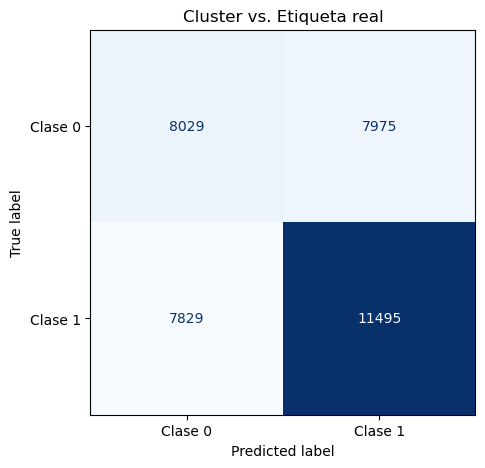

               precision    recall  f1-score   support

Clase 0 (G01)       0.51      0.50      0.50     16004
Clase 1 (G03)       0.59      0.59      0.59     19324

     accuracy                           0.55     35328
    macro avg       0.55      0.55      0.55     35328
 weighted avg       0.55      0.55      0.55     35328

Adjusted Rand Index:          0.010969094696207774
Normalized Mutual Info Score: 0.006784516067936746


In [23]:
# ─── Clustering de latentes (LSTM-AE) ───────────────────────────

# Parámetros
N_CLUSTERS, RANDOM_STATE = 2, 0

latents_list, true_labels_list = [], []
model.eval()

with torch.no_grad():
    for x_batch, meta in test_loader:
        # 1) Prepara meta
        meta = meta.permute(0, 2, 1)   # [B, 5, T]
        
        # 2) Datos a device
        x = x_batch.to(device)
        
        # 3) Extrae latentes
        z = model.encode(x)                      # [B, latent_dim]
        latents_list.append(z.cpu().numpy())
        
        # 4) Extrae etiquetas G01/G03 del canal 1
        grp = (meta[:, 1, 0] == 3.0).long().cpu().numpy()
        true_labels_list.append(grp)

# 5) Concatenar
latents     = np.concatenate(latents_list, axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

# 6) K-Means
cluster_labels = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=10
).fit_predict(latents)

# 7) Mapeo robusto cluster → etiqueta
mapping = {}
for c in np.unique(cluster_labels):
    idxs = np.where(cluster_labels == c)[0]
    most_common = Counter(true_labels[idxs]).most_common(1)[0][0]
    mapping[c] = most_common

aligned = np.vectorize(mapping.get)(cluster_labels)

# 8) Métricas
acc = accuracy_score(true_labels, aligned)
cm  = confusion_matrix(true_labels, aligned)
print(f"Accuracy: {acc:.3f}")

fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", ax=ax, values_format="d", colorbar=False)
ticks = np.arange(N_CLUSTERS)
ax.set_xticks(ticks);  ax.set_yticks(ticks)
ax.set_xticklabels([f"Clase {i}" for i in ticks])
ax.set_yticklabels([f"Clase {i}" for i in ticks])
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Cluster vs. Etiqueta real")
plt.show()

print(classification_report(
    true_labels, aligned,
    labels=[0,1],
    target_names=["Clase 0 (G01)", "Clase 1 (G03)"]
))

print("Adjusted Rand Index:         ", adjusted_rand_score(true_labels, cluster_labels))
print("Normalized Mutual Info Score:", normalized_mutual_info_score(true_labels, cluster_labels))

In [ ]:
# ─── Clustering de latentes model convolutional ────────────────────────────────────

# Parámetros de clustering
N_CLUSTERS   = 2
RANDOM_STATE = 0

# ─── 2. Extraer latentes y etiquetas verdaderas ──────────────────
latents_list, true_labels_list = [], []
model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        # x_batch: [B, C, T]
        x = x_batch.to(device)
        _, z = model(x)  # (recon, z)
        latents_list.append(z.cpu().numpy())

        # extraer grupo de meta[:,1,0]: G01→1, G03→3 → binario 0/1
        grp = (meta[:, 1, 0] == 3).long().cpu().numpy()
        true_labels_list.append(grp)

# concatenar todo
latents     = np.concatenate(latents_list,     axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

# ─── 3. Clustering con KMeans ────────────────────────────────────
cluster_labels = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=10
).fit_predict(latents)

# ─── 4. Alinear etiquetas si la exactitud es < 50% ──────────────
print("true_labels dtype:", true_labels.dtype, "uniques:", np.unique(true_labels))
print("cluster_labels dtype:", cluster_labels.dtype, "uniques:", np.unique(cluster_labels))

acc = accuracy_score(true_labels, cluster_labels)
if acc < 0.5:
    cluster_labels = 1 - cluster_labels
    acc = 1 - acc
print(f"Clustering accuracy: {acc:.3f}")

# ─── 5. Matriz de confusión ──────────────────────────────────────
cm = confusion_matrix(true_labels, cluster_labels)
disp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d", colorbar=False)

# forzamos solo dos ticks (0 y 1)
ticks = np.arange(N_CLUSTERS)  # array([0,1])
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# asignamos las dos etiquetas
labels = [f"Clase {i}" for i in range(N_CLUSTERS)]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Cluster vs. Etiqueta real")
plt.show()

# ─── 6. Reporte detallado ────────────────────────────────────────
print(classification_report(
    true_labels,
    cluster_labels,
    labels=[0,1],  # especificamos ambas clases
    target_names=["Clase 0 (G01)", "Clase 1 (G03)"]
))

# ─── 7. Índices de Rand y Mutual Info ────────────────────────────
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index:          {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

In [ ]:
#To calculate silhouette and davies-bouldin scores 

sil = silhouette_score(latents, cluster_labels)
db  = davies_bouldin_score(latents, cluster_labels)
print(f"Silhouette score: {sil:.3f}, Davies–Bouldin: {db:.3f}")


Extrayendo etiquetas de grupo del conjunto de validación...
Número total de etiquetas de validación extraídas: 35328
Distribución de etiquetas de validación (0=G01, 1=G03):
(array([0]), array([35328]))


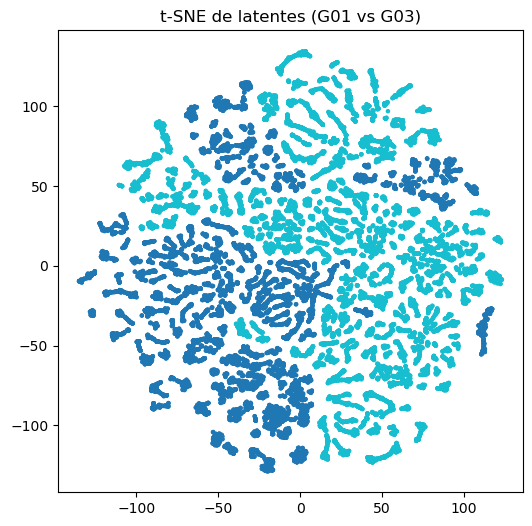

In [27]:
# To visualize the clustering results with t-SNE
Z2 = TSNE(n_components=2, random_state=0).fit_transform(latents)
plt.figure(figsize=(6,6))
plt.scatter(Z2[:,0], Z2[:,1], c=true_labels, cmap='tab10', s=5)
plt.title('t-SNE de latentes (G01 vs G03)')
plt.show()


In [36]:
#To visualize the clustering results with t-SNE in 3D 
# 1) Normaliza (opcional) y calcula t-SNE 3D
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np

# asumiendo que ya tienes latents y true_labels en tu sesión
X = StandardScaler().fit_transform(latents)
tsne3 = TSNE(n_components=3, random_state=0)
Z3   = tsne3.fit_transform(X)  # shape = (n_samples, 3)

# 2) Gráfico interactivo con Plotly
import plotly.express as px

fig = px.scatter_3d(
    x=Z3[:,0],
    y=Z3[:,1],
    z=Z3[:,2],
    color=true_labels.astype(str),
    labels={"color":"Grupo"},
    title="t-SNE 3D de latentes (G01 vs G03)",
    width=800, height=600
)

fig.update_traces(marker=dict(size=3))
fig.show()



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=500)
scores = cross_val_score(clf, latents, true_labels, cv=5, scoring='accuracy')
print("Supervised baseline (LR) CV accuracy:", scores.mean())


Supervised baseline (LR) CV accuracy: 0.9971408551341522


In [29]:
#Clustering with Gaussian Mixture Model (GMM)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

gmm = GaussianMixture(n_components=2,
                      covariance_type='full',
                      random_state=0).fit(latents)
labels_gmm = gmm.predict(latents)
print("Silhouette GMM:", silhouette_score(latents, labels_gmm))


Silhouette GMM: 0.1000319


In [30]:
#Clustring with spectral clustering
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=2,
                        affinity='nearest_neighbors',
                        n_neighbors=10,
                        random_state=0).fit_predict(latents)
print("Silhouette Spectral:", silhouette_score(latents, sc))


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Silhouette Spectral: 0.22463056


In [32]:
#Clustering with HDBSCAN
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=50).fit(latents)
labels_hdb = hdb.labels_
print("Clusters HDBSCAN:", set(labels_hdb))
print("Silhouette HDBSCAN:", silhouette_score(latents, labels_hdb))


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters HDBSCAN: {0, 1, 2, -1}
Silhouette HDBSCAN: 0.25589198


In [34]:
#Ajustar hdbscan para 2 clusters 
hdb = hdbscan.HDBSCAN(min_cluster_size=100,
                      cluster_selection_epsilon=0.5,
                      prediction_data=True).fit(latents)
labels_hdb = hdb.labels_  # -1 = ruido
# Ignora ruido para la métrica:
mask = labels_hdb != -1
ari_hdb = adjusted_rand_score(true_labels[mask], labels_hdb[mask])
nmi_hdb = normalized_mutual_info_score(true_labels[mask], labels_hdb[mask])
print(f"HDBSCAN (sin ruido) → ARI: {ari_hdb:.3f}, NMI: {nmi_hdb:.3f}")

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN (sin ruido) → ARI: 0.008, NMI: 0.035


In [33]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# sc es tu array de etiquetas de SpectralClustering
ari_spec = adjusted_rand_score(true_labels, sc)
nmi_spec = normalized_mutual_info_score(true_labels, sc)
print(f"Spectral → ARI: {ari_spec:.3f}, NMI: {nmi_spec:.3f}")


Spectral → ARI: 0.009, NMI: 0.022


# Clustering per patient 

In [38]:
import numpy as np
import torch
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
import pandas as pd

# --- 1. Extraer latentes y etiquetas verdaderas ---
latents_list = []
true_labels_list = []

model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        # 1.1. Pasa datos a device
        x = x_batch.to(device)
        # 1.2. Reordena meta a [B, features_meta, T]
        meta = meta.permute(0, 2, 1)
        # 1.3. Extrae ID de paciente: asumimos que está en el canal 0 y es constante en el tiempo
        #      Si tu meta tiene otra estructura, ajusta esta línea.
        patient_ids = meta[:, 0, 0].cpu().numpy().astype(int)

        # 1.4. Calcula latentes
        z = model.encode(x)        # (B, latent_dim)
        latents_list.append(z.cpu().numpy())
        true_labels_list.append(patient_ids)

# Concatena todos los batches
latents = np.concatenate(latents_list, axis=0)   # (N, latent_dim)
y_true  = np.concatenate(true_labels_list, axis=0)  # (N,)

# --- 2. Clustering con HDBSCAN (no se fuerza k) ---
clusterer = HDBSCAN(min_cluster_size=3)
y_pred = clusterer.fit_predict(latents)  # etiquetas de clúster, ruido = -1

# --- 3. Métricas de evaluación ---
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

# --- 4. Cálculo de pureza por paciente ---
def purity_by_patient(y_true, y_pred):
    purities = {}
    for p in np.unique(y_true):
        mask = (y_true == p)
        clusters_p = y_pred[mask]
        if clusters_p.size == 0:
            purities[p] = np.nan
        else:
            most_common, count = Counter(clusters_p).most_common(1)[0]
            purities[p] = count / clusters_p.size
    return purities

pur_by_patient = purity_by_patient(y_true, y_pred)
avg_purity = np.nanmean(list(pur_by_patient.values()))
print(f"Pureza promedio por paciente: {avg_purity:.2%}")
print("Pureza individual:")
for p, pur in pur_by_patient.items():
    print(f"  Paciente {p}: {pur:.2%}")

# --- 5. Matriz de contingencia (pacientes vs. clústeres) ---
conf_mat = pd.crosstab(y_true, y_pred,
                       rownames=['Paciente'],
                       colnames=['Clúster'])
print("Matriz de contingencia:")
print(conf_mat)


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



ARI: 0.026
NMI: 0.464
Pureza promedio por paciente: 14.31%
Pureza individual:
  Paciente 2: 9.31%
  Paciente 8: 15.22%
  Paciente 13: 9.73%
  Paciente 18: 32.45%
  Paciente 21: 13.44%
  Paciente 104: 10.81%
  Paciente 107: 13.88%
  Paciente 119: 13.65%
  Paciente 120: 14.72%
  Paciente 125: 9.85%
Matriz de contingencia:
Clúster   -1      0      1      2      3      4      5      6      7     \
Paciente                                                                  
2           446      0      0      0      0      0      0      0      0   
8           619      4      0      0      0      4     14      0     11   
13          208      0      0      0      0      0      0      0      0   
18         1163      0      0      0      0      0      0      0      0   
21          479      0      0      0      0      0      0      0      0   
104         249      0      0      2      0      0      0      8      0   
107         596      0      0      0      0      0      0      0      0   
119

In [39]:
# rangos a probar
min_sizes   = [3, 5, 10, 20]
min_samples = [1, 3, 5, None]  # None equivale a usar el valor default de HDBSCAN

results = []
for mcs in min_sizes:
    for ms in min_samples:
        hdb = HDBSCAN(min_cluster_size=mcs,
                      min_samples=ms if ms is not None else mcs)
        y_pred = hdb.fit_predict(latents)
        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
        # pureza promedio
        pur = np.nanmean(list(purity_by_patient(y_true, y_pred).values()))
        results.append((mcs, ms, ari, nmi, pur))

df = pd.DataFrame(results, columns=[
    "min_cluster_size", "min_samples", "ARI", "NMI", "pureza_avg"
])
print(df.sort_values("ARI", ascending=False))

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_fini

    min_cluster_size  min_samples       ARI       NMI  pureza_avg
11                10          NaN  0.166756  0.513350    0.334695
14                20          5.0  0.134928  0.526374    0.247013
12                20          1.0  0.086547  0.519282    0.151580
13                20          3.0  0.084191  0.516739    0.182706
9                 10          3.0  0.073705  0.501887    0.156671
10                10          5.0  0.066624  0.495841    0.194354
2                  3          5.0  0.059562  0.484270    0.185244
6                  5          5.0  0.059408  0.485582    0.185743
7                  5          NaN  0.059408  0.485582    0.185743
8                 10          1.0  0.032818  0.491192    0.108023
5                  5          3.0  0.030907  0.477125    0.132626
4                  5          1.0  0.028469  0.479104    0.103218
1                  3          3.0  0.026396  0.463809    0.143055
3                  3          NaN  0.026396  0.463809    0.143055
0         

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/umap/spectral.py:548

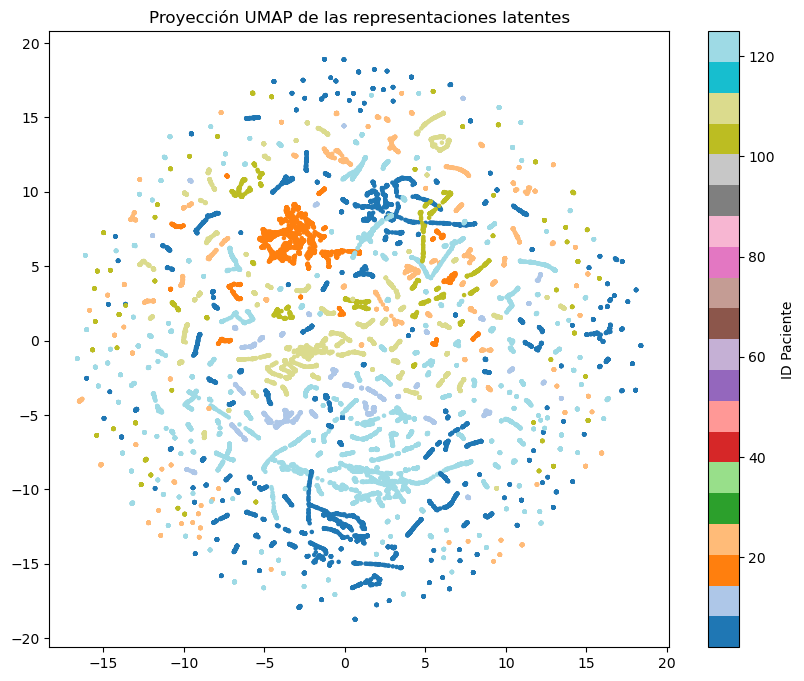

In [41]:
import umap
import matplotlib.pyplot as plt

# UMAP para reducción de dimensiones
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
latents_umap = umap_model.fit_transform(latents)

# Visualizar con matplotlib
plt.figure(figsize=(10, 8))
plt.scatter(latents_umap[:, 0], latents_umap[:, 1], c=y_true, cmap='tab20', s=5)
plt.title('Proyección UMAP de las representaciones latentes')
plt.colorbar(label='ID Paciente')
plt.show()
